In [1]:
import pandas as pd
import json
import os
import fsspec 
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
from azureml.core import Workspace
from azure.ai.ml import MLClient, Input, Output
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from azure.ai.ml.entities import Data
from azure.storage.blob import BlobClient, BlobServiceClient
from openai import AzureOpenAI
from azure.identity import DefaultAzureCredential

# Authenticate and create MLClient
credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential=credential)

Found the config file in: /config.json


In [2]:
# Use the o4-mini fine tuned model for inference
endpoint = "https://cogseraccrciru5aiyeus2.cognitiveservices.azure.com/"
model_name = "o4-mini"
ft_deployment = "o4-mini-2025-04-16-new_model_grader_run2"
token_provider = get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
api_version = "2024-12-01-preview"

ft_client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    azure_ad_token_provider=token_provider,
)

# Use the pv 04-mini for scoring and to generate 'base' answers
pv_deployment = "o4-mini"

pv_client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,    
    azure_ad_token_provider=token_provider
)


In [4]:
# Get the holdout dataset
# Define the path to your JSONL file
jsonl_path = "abfs://destadls2gzxfcx6xwhxssc/SRC/working_files/train_data_v4.jsonl"

# Use fsspec with adlfs backend
fs = fsspec.filesystem(
    "abfs",
    account_name="destadls2gzxfcx6xwhxssc",
    credential="FDCRYJMDH9pmpHL2xg6903AmPOQZwmLRPg/Z99Lg1Dldw6j9ABiQGpdmoyBRGDyWYyTTI4fzwVMq+ASt7I5vUw=="  
)

# Read the JSONL file into a Pandas DataFrame
with fs.open(jsonl_path, 'r') as f:
    df = pd.read_json(f, lines=True)

In [5]:
# Use this to extract the question

# Assuming your DataFrame is named df and the column is 'messages'
def extract_question_text(cell):
    if isinstance(cell, list) and len(cell) == 1 and isinstance(cell[0], dict):        
        content = cell[0].get('content', '')
        match = re.search(r'Question:\n(.*?)\nAnswer', content, re.DOTALL)
        if match:            
            return match.group(1).strip()        
    return None

# Apply the function to the DataFrame
df['extracted_question'] = df['messages'].apply(extract_question_text)

In [6]:
# Use this to extract the instructions/system prompt

def extract_prompt(message_list):
    try:
        content = message_list[0].get('content', '')
        first_index = content.find('Question:')
        if first_index != -1:
            return content[:first_index].strip()
        else:
            return ''
    except (IndexError, AttributeError):
        return ''

df['prompt'] = df['messages'].apply(extract_prompt)

In [7]:
# Use this to extract the balance of the message after removing the instructions/system prompt

def extract_full_message(message_list):
    try:
        content = message_list[0].get('content', '')
        first_index = content.find('Question:')
        if first_index != -1:
            return content[first_index:].strip()
        else:
            return ''
    except (IndexError, AttributeError):
        return ''

df['full_message'] = df['messages'].apply(extract_full_message)

In [8]:
# Use this to extract the POKA chunks

def extract_poka(message_list):
    try:
        content = message_list[0].get('content', '')
        first_index = content.find('Relevant Information Chunks::')
        if first_index != -1:
            first_index = first_index + len('Relevant Information Chunks::')
            return content[first_index:].strip()
        else:
            return ''
    except (IndexError, AttributeError):
        return ''

df['poka_chunks'] = df['messages'].apply(extract_poka)

In [9]:
# Use this to extract the Full FT answer

def extract_full_ft_answer(message_list):
    try:
        content = message_list[0].get('content', '')
        first_index = content.find('Answer from the finetuning:')
        second_index = content.find('Relevant Information Chunks::')
        if first_index != -1:
            first_index = first_index + len('Answer from the finetuning:')
            return content[first_index:second_index].strip()
        else:
            return ''
    except (IndexError, AttributeError):
        return ''

df['full_ft_answer'] = df['messages'].apply(extract_full_ft_answer)

In [10]:
# Extract the answer generated by the CoT checklist
df['ckp_answer'] = df['reference_answer'].apply(lambda x:x['answer'])

In [11]:
# Columns for the model answers
df['o4_ft_answer'] = ''
df['o4_pv_answer'] = ''

In [12]:
def gen_response(client, prompt, content, model, tokens = 32678):
  response = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": prompt,
        },
        {
            "role": "user",
            "content": content,
        }
    ],
    max_completion_tokens=tokens,
    model=model
    )
  return response


In [13]:
df['prompt'][0]

"you are a tax advisor. I need your help with the following:\nYou'll be provided with three elements:\n1. A client question\n2. Relevant information chunks\n3. An answer previously generated by another advisor that is referred to as 'Answer from the finetuning'\nYour task is to:\n1. Carefully analyze the question and the relevant information provided in the query\n2. Compare the other advisor's answer against the relevant information\n3. Provide your own comprehensive answer to the client's question\n4. Along with your answer, generate a list of follow-up questions that could help clarify or expand on the client's needs.\nGuidelines:\n- Use only finetuning answer and the relevant information provided in the query for your analysis\n- Never use your own knowledge to formulate your answer\n- Format your answer in a clear, professional manner with bullet points where appropriate\n- Present your response as a json with the following format {'followup_questions':[question1, question2, ...],

In [14]:
df['full_message'][20]

'Question:\nSuppose a new company in Guam is involved in both manufacturing and tourism development. How could it combine the available tax incentives and rebates to maximize its tax benefits, and what factors should it consider in its planning?\nAnswer from the finetuning:\nA new company in Guam engaged in both manufacturing and tourism development can significantly maximize its tax benefits by strategically combining the available tax incentives and rebates tailored to these sectors. Here’s how the company could approach this:\n\n**1. Utilization of Tax Incentives and Rebates:**\n- **Qualifying Certificate (QC) Program:** Guam offers a QC program through the Guam Economic Development Authority (GEDA), which provides tax rebates to companies that create new employment and expand industrial and commercial opportunities. Tourism and manufacturing businesses are specifically eligible for these QCs.\n    - **Tax Rebates:** Qualified companies can receive up to 75% (and in some cases, 100%

In [15]:
df.shape

(736, 10)

In [12]:
evaluation_list = [] 
bad_response_list = []
prompt = df['prompt'][0] + 'Return a JSON object. Do not escape quotes inside arrays. Use raw strings for array elements. Never return an empty response, if you cannot provide an answer say that you cannot do it'
for i in range (df.shape[0]):
    if (i%10 == 0):
        print('Iteration',i)
    #generate answers with the fine tuned and plain vanilla models
    user_content = df['full_message'][i]
    ft_response = gen_response(ft_client, prompt, user_content, ft_deployment)
    pv_response = gen_response(pv_client, prompt, user_content, pv_deployment)
    if ft_response.choices[0].message.model_dump()['content'] != None:
        try:
            ft_model_answer = json.loads(ft_response.choices[0].message.model_dump()['content'])['answer']                
        except json.JSONDecodeError as e:
            print('Fine-tuned response JSON error at line', i)
            bad_response_list.append({'line':i,'bad ft response':ft_response.choices[0].message.model_dump()['content']})
            continue
    else:
        print('Empty fine-tuned response at line', i)
        continue
    if pv_response.choices[0].message.model_dump()['content'] != None:
        try:
            pv_model_answer = json.loads(pv_response.choices[0].message.model_dump()['content'])['answer']                
        except json.JSONDecodeError as e:
            print('Plain vanilla response JSON error at line', i)
            bad_response_list.append({'line':i,'bad pv response':pv_response.choices[0].message.model_dump()['content']})
            continue
    else:
        print('Empty vanilla response at line', i)
        continue
    # try:
    #     pv_model_answer = json.loads(pv_response.choices[0].message.model_dump()['content'])['answer']                
    # except json.JSONDecodeError as e:
    #         print('Plain vanilla resposne JSON error at line', i)
    #         continue
    # Save the answers in the dataframe, rows for this iterration will be blank if JSON errors found above
    # df.loc[i,'o4_ft_answer'] = ft_model_answer
    # df.loc[i,'o4_pv_answer'] = pv_model_answer

    #Build a string for evaluation
    # Build a string to score and compare the answers
    input = ('question: '+ df['extracted_question'][i] + 
    'reference_answer: '+ df['ckp_answer'][i]+
    'base_answer: '+ pv_model_answer +
    'fine_tuned_answer: ' + ft_model_answer +
    'context: '+ df['full_message'][i])

    # Use the LLM to compare the model answer and the reference answer
    comparison = pv_client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": '''
            You are acting as a tax advisor. Your task is to evaluate three answers generated by different LLMs for a given tax question
            and determine which answer is the best according to a defined rubric.
            Inputs Provided:
            1. Question - The tax-related question.
            2. Context - Contains:
            - The question.
            - Relevant information chunks.
            - An answer previously generated by another advisor (referred to as 'Answer from the finetuning').
            3. Reference Answer - Generated using Chain-of-Thought (CoT).
            4. Base Answer - Generated by the base version of an LLM.
            5. Fine-Tuned Answer - Generated by a fine-tuned version of the same LLM.

            Task:
            - Score each of the three answers using the Rubric below.
            - Assign one score per answer in the range [0, 1].
            - Select the answer with the highest score as the best answer.
            - The best answer must be one of the following:  'reference_answer', 'base_answer', or 'fine_tuned_answer'

            Detailed Rubric (equal weight for all criteria):

            1. Fidelity to Context (0-0.25):
            - 0.00-0.10: Answer relies heavily on outside knowledge or introduces unsupported claims.
            - 0.11-0.18: Minor use of outside knowledge or slight deviation from context.
            - 0.19-0.23: Mostly faithful to context with negligible external influence.
            - 0.24-0.25: Fully based on context, no external knowledge detected.

            2. Accuracy (0-0.25):
            - 0.00-0.10: Major factual errors or contradictions; irrelevant claims.
            - 0.11-0.18: Some inaccuracies or contradictions; multiple irrelevant points.
            - 0.19-0.23: Mostly accurate with minor issues; no major contradictions.
            - 0.24-0.25: All claims accurate and relevant; no contradictions.

            3. Coverage (0-0.25):
            - 0.00-0.10: Misses most key points; incomplete response.
            - 0.11-0.18: Covers some aspects but omits multiple important details.
            - 0.19-0.23: Covers most key points; minor omissions only.
            - 0.24-0.25: Fully addresses intent and scope; no omissions.

            4. Clarity & Professionalism (0-0.25):
            - 0.00-0.10: Disorganized, verbose, or unclear; unprofessional tone.
            - 0.11-0.18: Some structural issues; tone acceptable but lacks polish.
            - 0.19-0.23: Clear and professional with minor structural flaws.
            - 0.24-0.25: Well-structured, concise, logical, and professional.

            Scoring Guidance:
            - Total score = sum of all four criteria (max = 1.0).
            - Apply caps:
            - ≤ 0.20 if major factual errors or contradictions exist.
            - ≤ 0.50 if multiple key points are missing or misrepresented.
            - ≤ 0.80 if mostly correct but missing 1-2 minor details.
            - ≥ 0.90 only if complete in scope and meets all criteria.

            Output Format:
            Return your evaluation as a pure JSON. 
            - All numeric values must be valid JSON numbers - no quotes, no words
            - Do not add any text outside the JSON
            - Do not output a triple-quoted string
            - Do not preface with the word json
            - Use this exact structure
            {
            "best_answer": "base_answer|fine_tuned_answer|reference_answer",
            "reference_answer_score": <number>,
            "base_answer_score": <number>,
            "fine_tuned_answer_score": <number>,
            "reference_answer_scoring_reasoning": "<string>",
            "base_answer_scoring_reasoning": "<string>",
            "fine_tuned_answer_scoring_reasoning": "<string>"
            }
        '''
        },
        {
            "role": "user",
            "content": input,
        }
    ],
    max_completion_tokens=32768,
    model=pv_deployment
    )
    try:
        evaluation_response = json.loads(comparison.choices[0].message.content)
    except json.JSONDecodeError as e:
            print('Answer comparison response JSON error at line', i)
            bad_response_list.append({'line':i,'bad comparisonresponse':comparison.choices[0].message.content})
            continue
    # Append the comparison response to the list
    evaluation_list.append(evaluation_response) 
    # Save the answers in the dataframe, rows for this iterration will be blank if JSON errors found above
    df.loc[i,'o4_ft_answer'] = ft_model_answer
    df.loc[i,'o4_pv_answer'] = pv_model_answer


Iteration 0
Plain vanilla response JSON error at line 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Fine-tuned response JSON error at line 40
Iteration 50
Iteration 60
Plain vanilla response JSON error at line 62
Empty fine-tuned response at line 64


In [ ]:
partial_results = pd.DataFrame(evaluation_list)
partial_results.to_csv('answer_scores_for_train_data_v1.csv', index=False)
print('Answer scores shape',partial_results.shape)
df.to_csv('df_with_answers_train_data_v1.csv', index=False)
print('Input shape',df.shape)

In [ ]:
partila

In [ ]:
df[df['o4_pv_answer']== '']

In [1]:
# Just to print from a previous run
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# partial_results = pd.read_csv('answer_scores_v7_2epochs.csv')

In [2]:
partial_results.columns

Index(['best_answer', 'reference_answer_score', 'base_answer_score',
       'fine_tuned_answer_score', 'reference_answer_scoring_reasoning',
       'base_answer_scoring_reasoning', 'fine_tuned_answer_scoring_reasoning'],
      dtype='object')

In [2]:
partial_results['best_answer'].value_counts()

best_answer
fine_tuned_answer    36
reference_answer     30
base_answer          16
Name: count, dtype: int64

In [3]:
partial_results[['reference_answer_score','base_answer_score','fine_tuned_answer_score']].describe()

,reference_answer_score,base_answer_score,fine_tuned_answer_score
count,82.000000,82.000000,82.000000
mean,0.947927,0.900000,0.916707
std,0.072021,0.143389,0.159010
min,0.450000,0.200000,0.200000
25%,0.940000,0.900000,0.932500
50%,0.960000,0.950000,0.970000
75%,0.980000,0.970000,1.000000
max,1.000000,1.000000,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

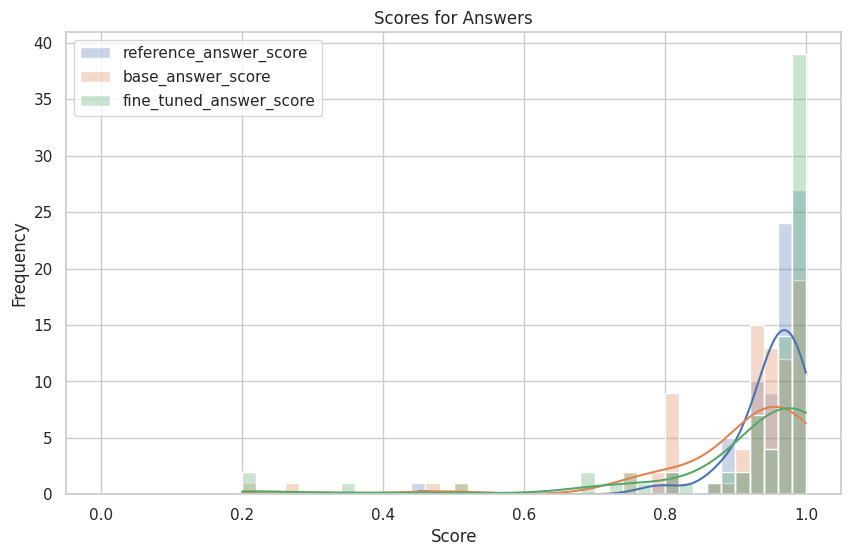

In [4]:
# Set Seaborn style
sns.set(style= 'whitegrid')

# Overlay histograms
plt.figure(figsize = (10,6))
for column in ['reference_answer_score','base_answer_score','fine_tuned_answer_score']:
    sns.histplot(partial_results[column], bins = 50, binrange = (0,1), kde=True, label=column, alpha = 0.3)
plt.title('Scores for Answers')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout
plt.show

In [ ]:
# ft_response.choices[0].message.model_dump()['content']

In [5]:
twostep_v_ft = partial_results['reference_answer_score']- partial_results['fine_tuned_answer_score']
twostep_v_pv = partial_results['reference_answer_score']- partial_results['base_answer_score']
ft_v_pv = partial_results['fine_tuned_answer_score']- partial_results['base_answer_score'] 

/tmp/ipykernel_7989/2171949733.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

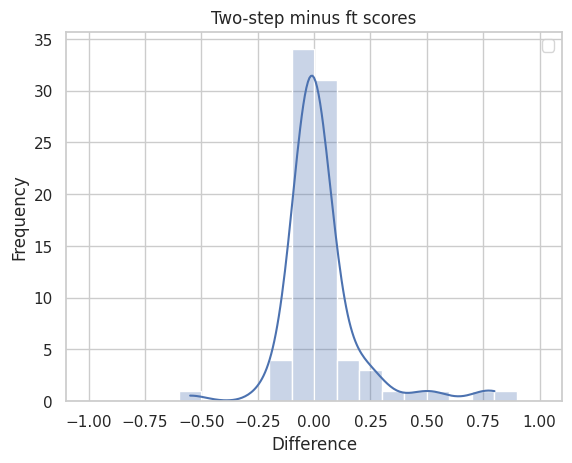

In [6]:
sns.histplot(twostep_v_ft, bins = 20,binrange = (-1,1), kde=True, label=None, alpha = 0.3)
plt.title('Two-step minus ft scores')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout
plt.show

/tmp/ipykernel_7989/4273583622.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

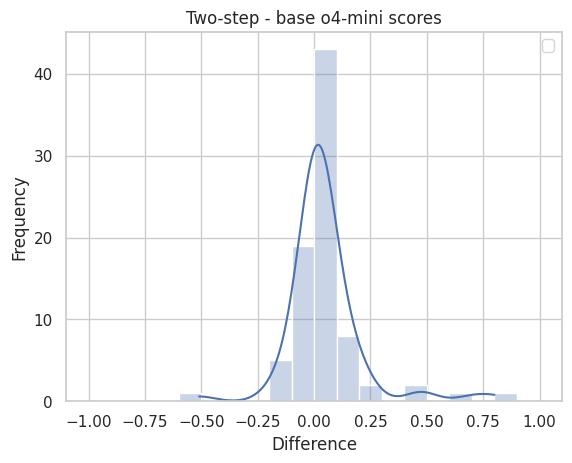

In [7]:
sns.histplot(twostep_v_pv, bins = 20,binrange = (-1,1), kde=True, alpha = 0.3)
plt.title('Two-step - base o4-mini scores')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout
plt.show

/tmp/ipykernel_7989/816166489.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<function matplotlib.pyplot.show(close=None, block=None)>

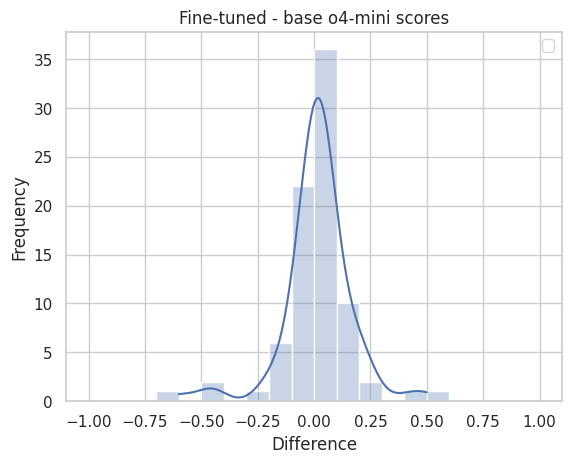

In [8]:
sns.histplot(ft_v_pv, bins = 20,binrange = (-1,1), kde=True, alpha = 0.3)
plt.title('Fine-tuned - base o4-mini scores')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout
plt.show

In [ ]:
# prompt = df['prompt'][0]
# evaluation_list = [] 
# for i in range (df.shape[0]):
#     #generate the model answer
#     user_content = df['full_message'][i]
#     ft_response = ft_client.chat.completions.create(
#     messages=[
#         {
#             "role": "system",
#             "content": prompt,
#         },
#         {
#             "role": "user",
#             "content": user_content,
#         }
#     ],
#     max_completion_tokens=32768,
#     model=ft_deployment
#     )
#     # Extract the answer from the full response
#     # model_output = ft_response.choices[0].message.model_dump()['content']
#     # first_index = model_output.find('answer')
#     # first_index = first_index + len("answer") + 3
#     # second_index = 'follow_up'
#     try:
#         model_answer = json.loads(ft_response.choices[0].message.model_dump()['content'])['answer']
#         # model_answer = model_output
#         df.loc[i,'o4_ft_answer'] = model_answer
#     except json.JSONDecodeError as e:
#             print('JSON error at line', i)

    
    # # Build a string to score and compare the answers
    # input = 'question: '+ df['extracted_question'][i] + 'reference_answer: '+ df['ckp_answer'][i]+'generated_answer: '+ model_answer

    # # Use the LLM to compare the model answer and the reference answer
    # comparison = pv_client.chat.completions.create(
    # messages=[
    #     {
    #         "role": "system",
    #         "content": '''
    #         You are given a question, a reference_answer and a generated_answer.
    #         Evaluate which of the two answers provides a beter response to the question based on: 
    #         1 - how well each answers all aspects of the question (70%) 
    #         2 - the readability of the answers (30%)
    #         3 - all scores in the [0,1] range
    #         Return your answer as a json with this format:
    #         {'best_answer': string,
    #         'generated_answer_scores: [aspect coverage score, readability score, combined score],
    #         'reference_answer_scores: [aspect coverage score, readability score, combined score],
    #         'generated_answer_scoring_reasoning': string
    #         'reference_answer_scoring_reasoning': string"
    #     '''
    #     },
    #     {
    #         "role": "user",
    #         "content": input,
    #     }
    # ],
    # max_completion_tokens=32768,
    # model=deployment
    # )
    # evaluation_list.append(json.loads(comparison.choices[0].message.content))